In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_csv("../Data/heart_disease_uci.csv")

# Display initial data overview
print("Initial data shape:", df.shape)
print("Missing values per column before cleaning:")
print(df.isnull().sum())

# --- Dataset Cleaning/Preprocessing Block ---
# Separate numeric and categorical columns.
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

# Filling missing values for numeric columns with the median.
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Filling missing values for categorical columns with the mode.
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0]).infer_objects()

print("\nMissing values per column after cleaning:")
print(df.isnull().sum())

# --- Preprocessing Pipeline ---
# Identify categorical and numerical features.
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numeric_features = df.select_dtypes(include=['number']).columns.tolist()

# Remove target columns ('chol' and 'num' are targets)
if "chol" in numeric_features:
    numeric_features.remove("chol")
if "num" in numeric_features:
    numeric_features.remove("num")

# Define imputers (this is now more useful if you plan to process new, uncleaned data)
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Build the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', numeric_imputer),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', categorical_imputer),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

Initial data shape: (920, 15)
Missing values per column before cleaning:
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Missing values per column after cleaning:
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


C:\Users\Daniel Esguerra\AppData\Local\Temp\ipykernel_15312\1916198902.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0]).infer_objects()


In [24]:
# --- Splitting Features and Targets ---
X = df.drop(columns=["chol", "num"])  # Features
y_reg = df["chol"]                    # Regression target
y_clf = (df["num"] > 0).astype(int)     # Binary classification target

# Verify that there are no missing values in the targets
print("Missing values in y_reg:", y_reg.isnull().sum())
print("Missing values in y_clf:", y_clf.isnull().sum())

# --- Train-Test Split ---
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

Missing values in y_reg: 0
Missing values in y_clf: 0


In [25]:
# --- Transform Features using the Preprocessing Pipeline ---
X_train_reg = preprocessor.fit_transform(X_train_reg)
X_test_reg = preprocessor.transform(X_test_reg)
X_train_clf = preprocessor.fit_transform(X_train_clf)
X_test_clf = preprocessor.transform(X_test_clf)

# --- Regression Model - ElasticNet ---
alpha_values = np.logspace(-2, 1, 10)
l1_ratios = np.linspace(0, 1, 10)

best_r2, best_rmse, best_alpha, best_l1 = -np.inf, np.inf, None, None
r2_results, rmse_results = [], []

for alpha in alpha_values:
    r2_row, rmse_row = [], []
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42, max_iter=5000)
        model.fit(X_train_reg, y_train_reg)
        y_pred = model.predict(X_test_reg)
        r2 = r2_score(y_test_reg, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
        r2_row.append(r2)
        rmse_row.append(rmse)
        if r2 > best_r2:
            best_r2, best_rmse, best_alpha, best_l1 = r2, rmse, alpha, l1_ratio
    r2_results.append(r2_row)
    rmse_results.append(rmse_row)

print("Best ElasticNet configuration:")
print("Alpha:", best_alpha, "L1 Ratio:", best_l1)
print("Best R2:", best_r2, "Best RMSE:", best_rmse)


d:\Desktop\BINF5507\.pixi\envs\default\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e+06, tolerance: 8.745e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
d:\Desktop\BINF5507\.pixi\envs\default\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.987e+06, tolerance: 8.745e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

Best ElasticNet configuration:
Alpha: 0.21544346900318834 L1 Ratio: 1.0
Best R2: 0.5568828089789966 Best RMSE: 72.39058114775477


d:\Desktop\BINF5507\.pixi\envs\default\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.181e+06, tolerance: 8.745e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
d:\Desktop\BINF5507\.pixi\envs\default\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.276e+06, tolerance: 8.745e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

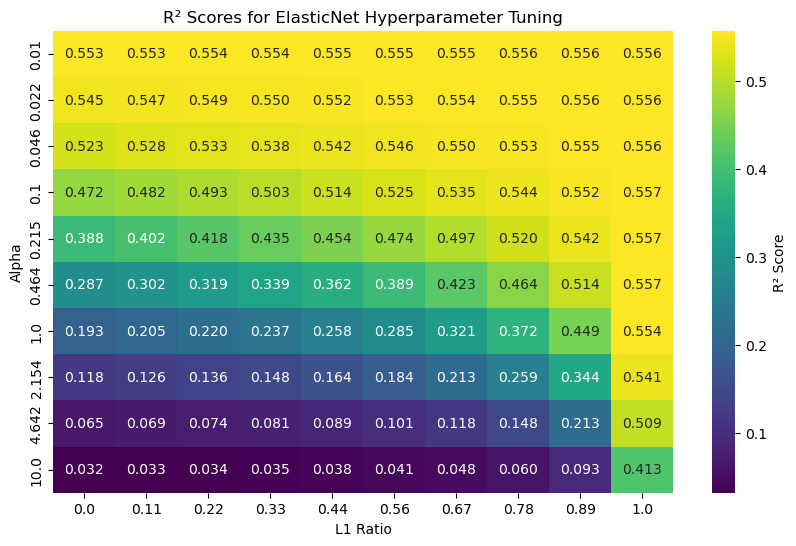

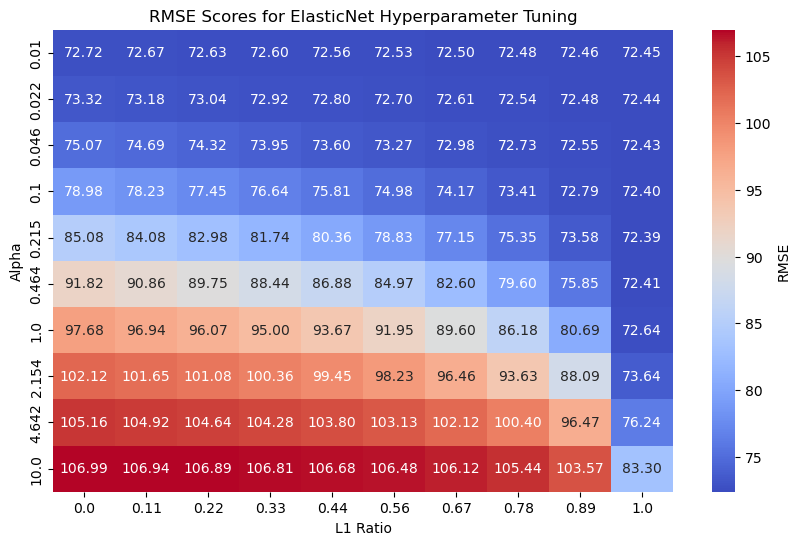

In [26]:
# Provided data from the loop
alpha_values = np.logspace(-2, 1, 10)
l1_ratios = np.linspace(0, 1, 10)

# Assuming r2_results and rmse_results have been computed from your loop
# Make sure these are numpy arrays for easy plotting
r2_results = np.array(r2_results)
rmse_results = np.array(rmse_results)

# Plot R² heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(r2_results, annot=True, fmt=".3f", xticklabels=np.round(l1_ratios, 2), 
            yticklabels=np.round(alpha_values, 3), cmap="viridis", cbar_kws={'label': 'R² Score'})
plt.xlabel("L1 Ratio")
plt.ylabel("Alpha")
plt.title("R² Scores for ElasticNet Hyperparameter Tuning")
plt.show()

# Plot RMSE heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(rmse_results, annot=True, fmt=".2f", xticklabels=np.round(l1_ratios, 2), 
            yticklabels=np.round(alpha_values, 3), cmap="coolwarm", cbar_kws={'label': 'RMSE'})
plt.xlabel("L1 Ratio")
plt.ylabel("Alpha")
plt.title("RMSE Scores for ElasticNet Hyperparameter Tuning")
plt.show()

Best Logistic Regression Parameters: {'C': 10, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best KNN Parameters: {'algorithm': 'auto', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
Tuned Logistic Regression Accuracy: 0.8261
Tuned K-NN Accuracy: 0.8424
Tuned Logistic Regression F1 Score: 0.8462
Tuned K-NN F1 Score: 0.8651
Tuned Logistic Regression AUROC: 0.8917
Tuned K-NN AUROC: 0.8872
Tuned Logistic Regression AUPRC: 0.9156
Tuned K-NN AUPRC: 0.8864


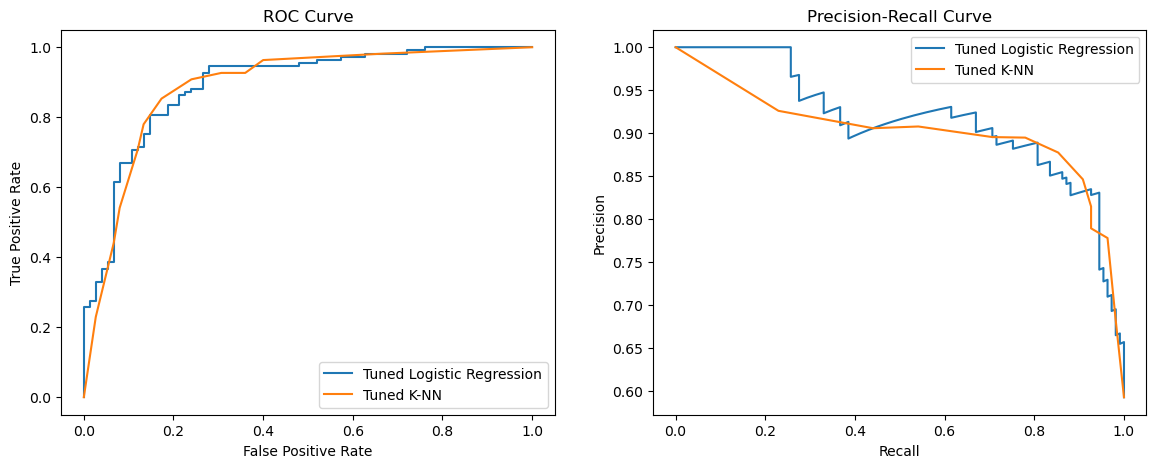

In [27]:
## Logistic Regression and K-NN ##

# Define parameter grid
param_grid_log = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strengths
    'solver': ['liblinear', 'saga'],  # Supports both L1 and L2
    'max_iter': [500, 750, 1000]
}

# Run GridSearchCV
log_reg_tuned = GridSearchCV(LogisticRegression(), param_grid_log, cv=5, scoring="accuracy", n_jobs=-1)
log_reg_tuned.fit(X_train_clf, y_train_clf)

# Best parameters for LogReg
print("Best Logistic Regression Parameters:", log_reg_tuned.best_params_)

# Predictions
y_pred_log = log_reg_tuned.best_estimator_.predict(X_test_clf)
y_prob_log = log_reg_tuned.best_estimator_.predict_proba(X_test_clf)[:, 1]

# Define parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # Manhattan and Euclidean distances
}

# Run GridSearchCV
knn_tuned = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring="accuracy", n_jobs=-1)
knn_tuned.fit(X_train_clf, y_train_clf)

# Best parameters for KNN
print("Best KNN Parameters:", knn_tuned.best_params_)

# Predictions
y_pred_knn = knn_tuned.best_estimator_.predict(X_test_clf)
y_prob_knn = knn_tuned.best_estimator_.predict_proba(X_test_clf)[:, 1]

metrics = {
    "Accuracy": accuracy_score,
    "F1 Score": f1_score,
    "AUROC": roc_auc_score,
    "AUPRC": average_precision_score
}

for name, metric in metrics.items():
    if name in ['Accuracy', 'F1 Score']:
        print(f"Tuned Logistic Regression {name}: {metric(y_test_clf, y_pred_log):.4f}")
        print(f"Tuned K-NN {name}: {metric(y_test_clf, y_pred_knn):.4f}")
    else:
        print(f"Tuned Logistic Regression {name}: {metric(y_test_clf, y_prob_log):.4f}")
        print(f"Tuned K-NN {name}: {metric(y_test_clf, y_prob_knn):.4f}")

# Plot ROC and Precision-Recall Curves after hyperparameter tuning
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr_log, tpr_log, _ = roc_curve(y_test_clf, y_prob_log)
fpr_knn, tpr_knn, _ = roc_curve(y_test_clf, y_prob_knn)
ax[0].plot(fpr_log, tpr_log, label='Tuned Logistic Regression')
ax[0].plot(fpr_knn, tpr_knn, label='Tuned K-NN')
ax[0].set_title("ROC Curve")
ax[0].legend()
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")

# Precision-Recall Curve
prec_log, rec_log, _ = precision_recall_curve(y_test_clf, y_prob_log)
prec_knn, rec_knn, _ = precision_recall_curve(y_test_clf, y_prob_knn)
ax[1].plot(rec_log, prec_log, label='Tuned Logistic Regression')
ax[1].plot(rec_knn, prec_knn, label='Tuned K-NN')
ax[1].set_title("Precision-Recall Curve")
ax[1].legend()
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")

plt.show()